Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
       Artist Name  ...                                             Lyrics
0  Phoebe Bridgers  ...   I hate you for what you did And I miss you li...
1  Phoebe Bridgers  ...   Sometimes I think I'm a killer I scared you i...
2  Phoebe Bridgers  ...   Georgia, Georgia, I love your son And when he...
3  Phoebe Bridgers  ...   Day off in Kyoto Got bored at the temple Look...
4  Phoebe Bridgers  ...   Playing "would you rather" When it comes to f...

[5 rows x 3 columns]
+------------------------+-------------------------------+
|  Shape of The Dataset  |  Length of Unique Characters  |
+------------------------+-------------------------------+
|        (347, 3)        |               70              |
+------------------------+-------------------------------+ 

The Unique Characters:
[' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '

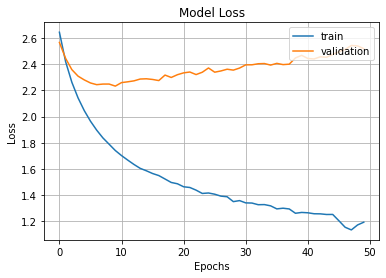

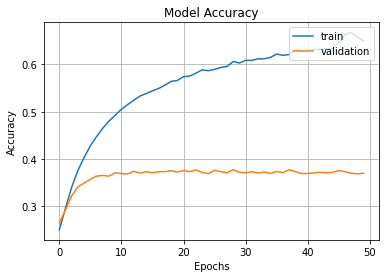

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log


poem  it's only been three weeks and a bag of mea iay m faa ' and what m whll gow you uprd me in the same out le a lot wo for to the hoou when you go   lav your sickoess down by mine your love can be my crime ma     ln oh love, love, love only l


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import string, os
import random
import keras
import nltk
import sys
import io
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.optimizers import Adamax
from keras.layers import LSTM, Dense, Dropout
from PIL import Image, ImageDraw, ImageFont
from keras.models import Sequential
from prettytable import PrettyTable
from keras.utils import np_utils
from google.colab import drive
from PIL import Image
drive.mount('/content/gdrive')
%matplotlib inline
np.random.seed(42)

class LyricsGenerator:
  def __init__(self,length):
    self.model = Sequential()
    self.corpus = ''
    self.length = length
    self.generatedPoem = ""
    
  def loadDataset(self):
    self.data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/mini project 2/LYRICS_DATASET.csv')
    print(self.data.head())
   
  def createCorpus(self):
    for listitem in self.data.Lyrics[:346]:
      if type(listitem) == str:
        self.corpus += listitem   
    self.corpus = self.corpus.lower() 

  def Lyrics_Generator(self, starter, Ch_count):
    starter = starter 
    seed=[self.mapping[char] for char in starter]
    self.generatedPoem += starter 
    for i in range(Ch_count):
        seed=[self.mapping[char] for char in starter]
        pred = np.reshape(seed, (1, len(seed), 1))
        pred = pred/ float(self.L_symb)
        pred_ = self.model.predict(pred, verbose=0)[0]  
        pred_ = np.asarray(pred_).astype('float64')
        pred_ = np.log(pred_) / 1.0 
        pred_ = np.exp(pred_) / np.sum(np.exp(pred_))
        probas = np.random.multinomial(1, pred_, 1)
        index = np.argmax(pred_)
        next_char = self.rvsMapping[index]  
        # Generating new text
        self.generatedPoem += next_char
        starter = starter[1:] + next_char

  def generate(self, starter, Ch_count):
    self.Lyrics_Generator(starter, Ch_count)

  def printDataDescription(self): 
    table = PrettyTable()
    column_names = [" Shape of The Dataset ", " Length of Unique Characters "]
    table.add_column(column_names[0], [self.data.shape])
    table.add_column(column_names[1], [len(set(self.corpus))])  
    print(table,'\n')
    print("The Unique Characters:",)
    print(sorted(set(self.corpus)),'\n')

  def processing(self):
    deletionList = ['{', '}', '~', '©', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ',
             'е', 'ا', 'س', 'ل', 'م', 'و', '\u2005', '\u200a', '\u200b', '–', '—', '‘', '’', '‚', '“', '”', 
             '…', '\u205f', '\ufeff', '!', '&', '(', ')', '*', '-',  '/', '\x93', '¡', '£', '¨']
    for x in deletionList:
      self.corpus = self.corpus.replace(x," ")
    print("The Unique Characters Corpus after remove unimportant symbols:")
    print(sorted(set(self.corpus)),'\n')
    
  def mappingDictionary(self):
    self.symb = sorted(list(set(self.corpus)))
    self.L_corpus = len(self.corpus)
    self.L_symb = len(self.symb)
    self.mapping = dict((c, i) for i, c in enumerate(self.symb))
    self.rvsMapping = dict((i, c) for i, c in enumerate(self.symb))
    table = PrettyTable()
    column_names = [" Length of All Characters After Remove Unimportant Symbols ", " Length of Unique Characters After Remove Unimportant Symbols "]
    table.add_column(column_names[0], [self.L_corpus])
    table.add_column(column_names[1], [self.L_symb])  
    print(table,'\n')
    self.features = []
    self.desireds = []
    for i in range(0, self.L_corpus - self.length, 1):
        self.feature = self.corpus[i:i + self.length]
        self.desired = self.corpus[i + self.length]
        self.features.append([self.mapping[j] for j in self.feature])
        self.desireds.append(self.mapping[self.desired])

  def train(self,loss='categorical_crossentropy', epochs=50):
    self.loss = loss
    self.epochs = epochs
    self.xTrain = (np.reshape(self.features, (len(self.desireds), self.length, 1)))/ float(self.L_symb)
    self.yTrain = np_utils.to_categorical(self.desireds)  
    self.train_()

  def train_(self):
    self.model.add(LSTM(300, input_shape=(self.xTrain.shape[1], self.xTrain.shape[2])))
    self.model.add(Dense(self.yTrain.shape[1], activation='softmax'))
    opt = Adamax(learning_rate=0.015)
    self.model.compile(loss=self.loss, optimizer=opt, metrics=['accuracy'])
    self.model.summary()
    self.result = self.model.fit(self.xTrain, self.yTrain, validation_split=0.15, batch_size=256, epochs=self.epochs)

  def plotLoss(self):    
    plt.figure(1)
    plt.plot(pd.DataFrame(self.result.history)["loss"])
    plt.plot(pd.DataFrame(self.result.history)["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid()
    plt.show()

  def plotAccuracy(self):    
    plt.figure(2)
    plt.plot(pd.DataFrame(self.result.history)["accuracy"])
    plt.plot(pd.DataFrame(self.result.history)["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend(['train', 'validation'], loc='upper right')
    plt.grid()
    plt.show()

if __name__ == '__main__':
  model = LyricsGenerator(length = 40)
  model.loadDataset()
  model.createCorpus()
  model.printDataDescription()
  model.processing()
  model.mappingDictionary()
  model.train(loss='KLDivergence', epochs=50)
  model.plotLoss()
  model.plotAccuracy()
  model.generate(" it's only been three weeks and a bag of", 200) 
  print('poem', model.generatedPoem)
